In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm
import h5py

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(6)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.0.67:59183 Dashboard: http://10.148.0.67:8787/status,Cluster Workers: 12 Cores: 48 Memory: 600.00 GB


---


# 1. LLC results

In [4]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
E_dir = '/home1/datawork/xyu/LLC4320/mit_zavg_spec/zavg_UV/constant_window/'
D = [xr.open_zarr(E_dir+'E_rotary_zavg_openocean_f%02d_1080.zarr'%(face)) for face in face_all] # open-ocean
ds = xr.concat(D, dim='face')
E = (ds.E*ds.A).sum(dim='face') / ds.A.sum(dim='face')
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
print(E)
df=E.freq_time[1]-E.freq_time[0]
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
f_cpd = f*86400/2./np.pi

<xarray.DataArray (lat: 120, freq_time: 1439)>
dask.array<shape=(120, 1439), dtype=float64, chunksize=(60, 720)>
Coordinates:
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
    freq_cpd   (freq_time) float64 -11.99 -11.98 -11.96 -11.94 -11.93 -11.91 ...


_________
# 2. Drifter Results

In [5]:
data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
ds_linear_window = xr.open_zarr(data_dir+'E_drifter_linear_window.zarr').chunk({'freq_time': 1440, 'lat_bins': 1}) 
E_drifter = ds_linear_window.E_drifter_linear_window
f_drifter = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_drifter.lat_bins))
f_cpd_drifter = f_drifter*86400/2./np.pi

_________
# 3. Global mean

In [6]:
# LLC4320 results
llc_dir = '/home1/datawork/xyu/LLC4320/mit_zavg_spec/zavg_UV/constant_window/'
ds_llc_cycl = xr.open_zarr(llc_dir+'E_cycl_all_openocean.zarr')
ds_llc_anti = xr.open_zarr(llc_dir+'E_anti_all_openocean.zarr')

E_llc_cycl = ds_llc_cycl.E_cycl_all
E_llc_anti = ds_llc_anti.E_anti_all

In [7]:
# Drifter - drogued
data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
ds = xr.open_zarr(data_dir+'E_drifter_qd_globalmean.zarr')
E_drifter_anti_qd = ds.E_drifter_anti
E_drifter_cycl_qd = ds.E_drifter_cycl

In [8]:
# Drifter - undrogued
data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
ds = xr.open_zarr(data_dir+'E_drifter_qu_globalmean.zarr')
E_drifter_anti_qu = ds.E_drifter_anti
E_drifter_cycl_qu = ds.E_drifter_cycl

In [9]:
# Drifter - drogued & GPS-tracked
data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
ds = xr.open_zarr(data_dir+'E_drifter_qd_globalmean_GPS.zarr')
E_drifter_anti_qd_GPS = ds.E_drifter_anti
E_drifter_cycl_qd_GPS = ds.E_drifter_cycl

In [10]:
# make freq negative

E_llc_anti = E_llc_anti.assign_coords(freq_time=E_llc_anti.freq_time * -1.) 
E_drifter_anti_qd = E_drifter_anti_qd.assign_coords(freq_time=E_drifter_anti_qd.freq_time * -1.) 
E_drifter_anti_qu = E_drifter_anti_qu.assign_coords(freq_time=E_drifter_anti_qu.freq_time * -1.) 
E_drifter_anti_qd_GPS = E_drifter_anti_qd_GPS.assign_coords(freq_time=E_drifter_anti_qd_GPS.freq_time * -1.) 

In [37]:
# tidal frequencies
ptidal_frequency = [0.825518, 0.856952, 0.861809, 0.893244, 0.898101, 0.929536, 0.935012, 0.96097, 0.966446, 0.971303, 0.994524, 0.997262, 1, 1.00274, 1.00548, 1.00821, 1.03417, 1.03903, 1.06499, 1.07046, 1.07594, 1.11223, 1.76053, 1.79196, 1.79682, 1.79744, 1.8234, 1.82826, 1.83373, 1.8536, 1.85907, 1.85969, 1.86455, 1.89051,1.89598,
1.90084,1.90693,1.9268,1.92742,1.92954,1.93227,1.93501,1.93775,1.94323,1.95823,1.96371,1.96857,1.99452,1.99726,2,2.00274,2.00548,2.03629,2.04177,2.04724,2.06773,2.07258,2.0732,2.10402,2.82552,2.86181,2.89841,2.89872,2.92954,2.93501,2.99726,3.00274,
3.76053,3.79196,3.79682,3.82278,3.82826,3.83373,3.85907,3.86455,3.87002,3.89598,3.90146,3.93227,3.93775,3.96857,4,4.00548,4.75779,4.79408,4.79956,4.83099,4.86181,4.86729,4.93501,4.94049,5.00274,5.69342,5.72424,5.72971,5.76053,5.76601,5.79135,5.79682,
5.82826,5.83373,5.85907,5.86455,5.87002,5.90146,5.93227,5.93775,6,6.69006,6.72698,6.76296,6.79408,6.79956,6.86729,7.65651,7.6928,7.69828,7.72909,7.76053,7.76601,7.79682,7.8023,7.83373,7.86455,7.87002,8.65925,8.69554,8.73183,8.79956,9.62508,9.66137,
9.6928,9.72909,9.76601,9.79682,10.7318,11.5936,11.6614,11.6983]

In [38]:
ntidal_frequency = [ -x for x in ptidal_frequency]

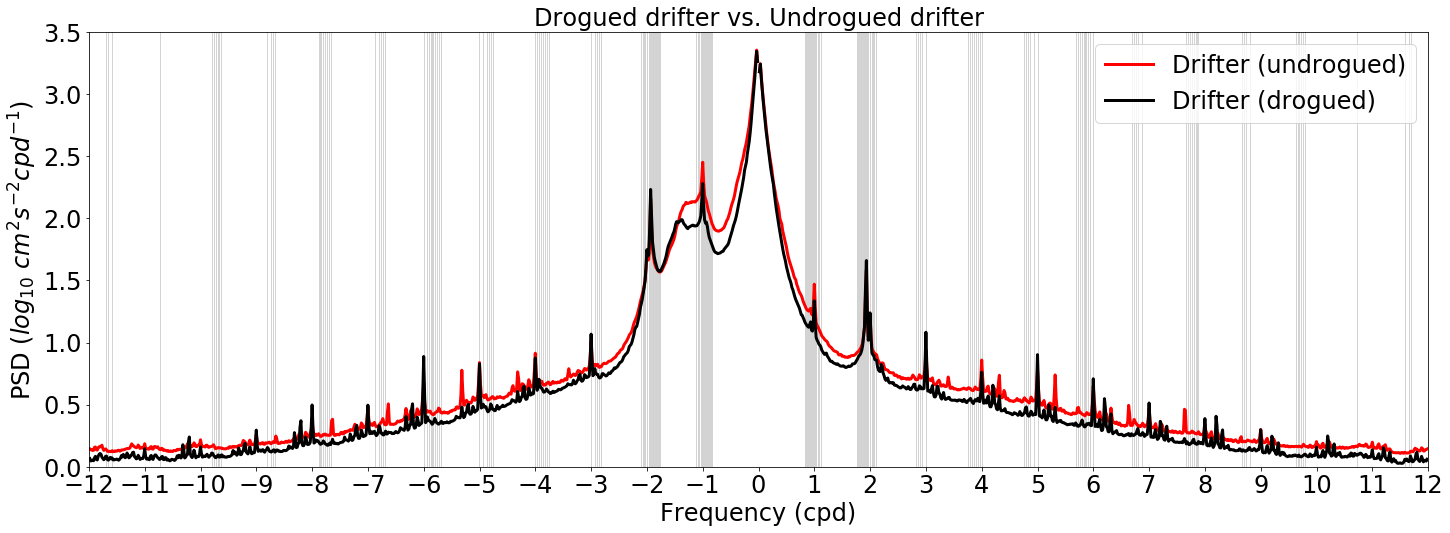

In [41]:
font_size = 24

fig, ax = plt.subplots(figsize=(24,8))


# Global averaged
ax = plt.subplot(111)

labels = ['Drifter (drogued)', 'Drifter (undrogued)','']
# tidal frequencies - vertical lightgrey lines
ax.plot([ptidal_frequency,ptidal_frequency],[-2,4], linewidth=1, color='lightgrey') 
ax.plot([ntidal_frequency,ntidal_frequency],[-2,4], linewidth=1, color='lightgrey') 
# drifter (drogued & GPS)
np.log10(E_drifter_cycl_qu).plot(ax=ax, linewidth=3, color='red', label=labels[1])
np.log10(E_drifter_anti_qu).plot(ax=ax, linewidth=3, color='red', label=labels[2])
# drifter (drogued)
np.log10(E_drifter_cycl_qd).plot(ax=ax, linewidth=3, color='black', label=labels[0])
np.log10(E_drifter_anti_qd).plot(ax=ax, linewidth=3, color='black', label=labels[2])
#ax.grid()
ax.set_ylim([0,3.5])
ax.set_yticks([0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5])
ax.set_xlim([-12.,12.])
ax.set_xticks([-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': font_size},loc="upper right")
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Drogued drifter vs. Undrogued drifter',fontsize=font_size)


plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_drogued_undrogued_drifter_comparison.png')


Text(0.5,1,'')

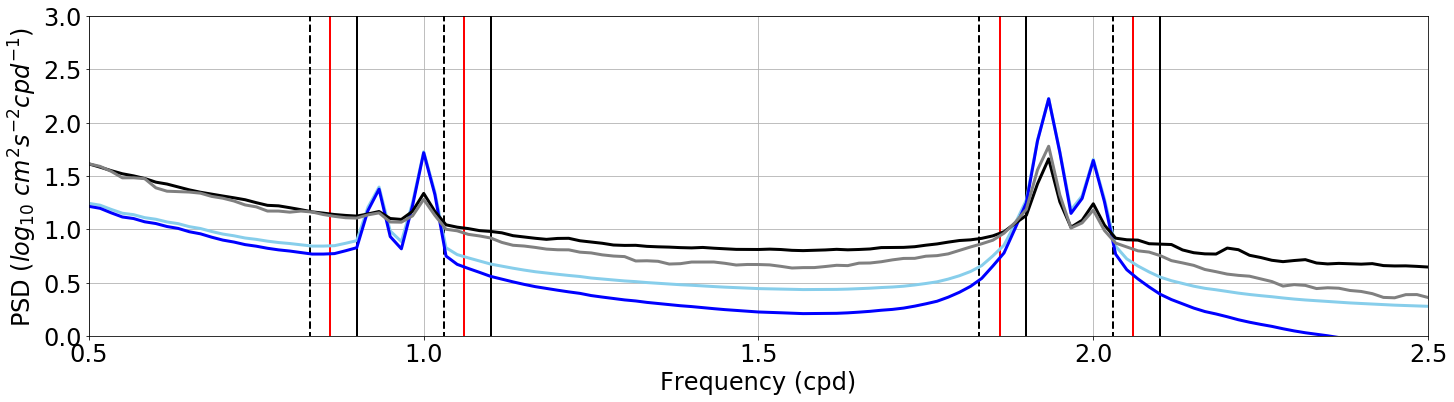

In [26]:
font_size = 24

fig, ax = plt.subplots(figsize=(24,20))


# Global averaged
ax = plt.subplot(3,2,(3,4))
labels = ['LLC4320','LLC4320 + Argos noise', 'Drifter (drogued)','', 'Drifter (drogued & GPS)']


ax.plot([0.9,0.9],[-2,4], linewidth=2, color='black')        # O1
ax.plot([1.1,1.1],[-2,4], linewidth=2, color='black')  # K1
ax.plot([2.1,2.1],[-2,4], linewidth=2, color='black')  # S2
ax.plot([1.9,1.9],[-2,4], linewidth=2, color='black')           # M2


ax.plot([0.83,0.83],[-2,4], 'k--', linewidth=2)        # O1
ax.plot([1.03,1.03],[-2,4], 'k--', linewidth=2)  # K1
ax.plot([2.03,2.03],[-2,4], 'k--', linewidth=2)  # S2
ax.plot([1.83,1.83],[-2,4], 'k--', linewidth=2)           # M2


ax.plot([0.86,0.86],[-2,4], 'r', linewidth=2)        # O1
ax.plot([1.06,1.06],[-2,4], linewidth=2, color='red')  # K1
ax.plot([1.86,1.86],[-2,4], 'r', linewidth=2)           # M2
ax.plot([2.06,2.06],[-2,4], linewidth=2, color='red')  # S2




ax.grid()
# llc + noise
np.log10(E_llc_anti+1.1).plot(ax=ax,linestyle='-',color='skyblue', label=labels[1], linewidth=3)
np.log10(E_llc_cycl+1.1).plot(ax=ax,linestyle='-',color='skyblue', label=labels[3], linewidth=3)
# llc
np.log10(E_llc_anti).plot(ax=ax,color='blue', label=labels[0], linewidth=3)
np.log10(E_llc_cycl).plot(ax=ax,color='blue', label=labels[3], linewidth=3)
# drifter (drogued)
np.log10(E_drifter_cycl_qd).plot(ax=ax, linewidth=3, color='black', label=labels[2])
np.log10(E_drifter_anti_qd).plot(ax=ax, linewidth=3, color='black', label=labels[3])
# drifter (drogued & GPS)
np.log10(E_drifter_cycl_qd_GPS).plot(ax=ax, linewidth=3, color='grey', label=labels[4])
np.log10(E_drifter_anti_qd_GPS).plot(ax=ax, linewidth=3, color='grey', label=labels[3])
ax.set_ylim([0,3])
ax.set_yticks([0., 0.5, 1., 1.5, 2., 2.5,3.])
ax.set_xlim([0.5,2.5])
ax.set_xticks([0.5,1,1.5,2,2.5])
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('',fontsize=font_size)

#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_LLC_drifter_comparison_zoomin_cycl.png')


# 4. Multi-try

In [15]:
# The prcessed dataset includes both the GPS- and Argo-tracked surface drifters.
# 2-month blocks with overlapping by 50%

data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'

drifter_dataset = h5py.File(data_dir+'Drifter_dataset_processed.mat','r') 
list(drifter_dataset.items())

# mlat2: mean latitude over 60 days,     157978*1
# mlon2: mean longitude over 60 days,    157978*1

# qd: drogued drifters,                  157978*1
# qmed200: median water depth > 200 m,   157978*1
# qu: undrogued drifters,                157978*1

# uv2: (u, v),                           157978*1440

[('dpth2', <HDF5 dataset "dpth2": shape (157978, 1440), type "<f8">),
 ('lat2_err', <HDF5 dataset "lat2_err": shape (157978, 1440), type "<f8">),
 ('lon2_err', <HDF5 dataset "lon2_err": shape (157978, 1440), type "<f8">),
 ('mdpth', <HDF5 dataset "mdpth": shape (157978, 1), type "<f8">),
 ('mlat2', <HDF5 dataset "mlat2": shape (157978, 1), type "<f8">),
 ('mlon2', <HDF5 dataset "mlon2": shape (157978, 1), type "<f8">),
 ('qall1000', <HDF5 dataset "qall1000": shape (157978, 1), type "|u1">),
 ('qall200', <HDF5 dataset "qall200": shape (157978, 1), type "|u1">),
 ('qall500', <HDF5 dataset "qall500": shape (157978, 1), type "|u1">),
 ('qd', <HDF5 dataset "qd": shape (157978, 1), type "|u1">),
 ('qmed1000', <HDF5 dataset "qmed1000": shape (157978, 1), type "|u1">),
 ('qmed200', <HDF5 dataset "qmed200": shape (157978, 1), type "|u1">),
 ('qmed500', <HDF5 dataset "qmed500": shape (157978, 1), type "|u1">),
 ('qu', <HDF5 dataset "qu": shape (157978, 1), type "|u1">),
 ('u2_err', <HDF5 dataset

In [16]:
# turn mean-lat into xarray_DataArray
lat2 = drifter_dataset['mlat2']
lat2 = np.array(lat2)
lat = xr.DataArray(lat2, dims=['lat', 'none'])
lat = xr.DataArray.squeeze(lat, dim='none')
lat = np.real(lat).rename('lat')
lat

<xarray.DataArray 'lat' (lat: 157978)>
array([ 44.219853,  44.908928,  44.856863, ..., -37.524563, -37.171366,
       -37.194084])
Dimensions without coordinates: lat

In [17]:
# turn mean-lat into xarray_DataArray
lon2 = drifter_dataset['mlon2']
lon2 = np.array(lon2)
lon = xr.DataArray(lon2, dims=['lon', 'none'])
lon = xr.DataArray.squeeze(lon, dim='none')
lon = np.real(lon).rename('lon')
lon

<xarray.DataArray 'lon' (lon: 157978)>
array([307.992707, 306.962722, 305.597501, ..., 325.844828, 326.138668,
       325.506414])
Dimensions without coordinates: lon

In [18]:
# turn drogued_information into xarray_DataArray
qd = drifter_dataset['qd']
qd = np.array(qd)
qd = xr.DataArray(qd, dims=['qd', 'none'])
qd = xr.DataArray.squeeze(qd, dim='none')
qd = np.real(qd).rename('qd')
qd

<xarray.DataArray 'qd' (qd: 157978)>
array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)
Dimensions without coordinates: qd

In [19]:
# (u,v) --> u+iv
uv = drifter_dataset['uv2'].value.view(np.double).reshape((157978, 1440, 2))
uv_drifters = uv[:,:,0] + 1j*uv[:,:,1]
uv_drifters.shape  # result is (10, 10, 10)
uv_drifters

array([[-0.2048+0.4936j, -0.3023+0.4859j, -0.2971+0.4856j, ...,
         0.1322+0.009j ,  0.1219-0.0239j, -0.0805-0.1172j],
       [ 0.1436+0.2085j,  0.1056+0.1783j,  0.0387+0.128j , ...,
         0.116 +0.075j ,  0.0779+0.2255j,  0.1379+0.195j ],
       [-0.1518-0.1663j, -0.1137-0.1704j, -0.1083-0.1446j, ...,
        -0.2145-0.3872j, -0.215 -0.3862j, -0.2145-0.3976j],
       ...,
       [ 0.3967+0.1554j,  0.4447+0.1624j,  0.4864+0.1736j, ...,
         0.072 +0.2357j,  0.0712+0.2299j,  0.0676+0.2051j],
       [ 0.1061+0.0992j,  0.074 +0.0919j,  0.0629+0.096j , ...,
         0.0589+0.0466j,  0.0513+0.0552j,  0.0395+0.0682j],
       [ 0.0622+0.164j ,  0.0589+0.1348j,  0.0671+0.121j , ...,
        -0.1189+0.0092j, -0.1027-0.0244j, -0.0739-0.0525j]])

In [20]:
# Drifter Dataset (u+iv,lat,qd,time)
ds = xr.Dataset({'uv_drifters': (['lat', 'time'], uv_drifters)},
                 coords={'lat': (['lat'], lat),
                         'lon': (['lat'], lon),
                         'time':(['time'], np.arange(1440)*3600),
                         'qd':(['lat'], qd)})
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:      (lat: 157978, time: 1440)
Coordinates:
  * lat          (lat) float64 44.22 44.91 44.86 43.76 42.22 46.44 46.08 ...
    lon          (lat) float64 308.0 307.0 305.6 305.5 309.8 307.8 307.6 ...
  * time         (time) int64 0 3600 7200 10800 14400 18000 21600 25200 ...
    qd           (lat) uint8 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 ...
Data variables:
    uv_drifters  (lat, time) complex128 (-0.2048+0.4936j) (-0.3023+0.4859j) ...

 data size: 3.6 GB


# 2. FFT

In [21]:
#uv_fft_complex = xrft.dft(ds.uv_drifters.fillna(0.), dim=['time'], shift=False, detrend='linear', window=True, chunks_to_segments=False)
uv_fft_complex = xrft.dft(ds.uv_drifters.where(ds.qd>0).fillna(0.), dim=['time'], shift=False, detrend='linear', window=True, chunks_to_segments=False)

E_uv_blocks = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/1440*3600
E_uv_blocks = np.real(E_uv_blocks).rename('E_uv_blocks')
E_uv_blocks = E_uv_blocks.assign_coords(freq_cpd=E_uv_blocks.freq_time * 86400.) 
E_uv_blocks = E_uv_blocks.assign_coords(lon=ds.lon) 
print(E_uv_blocks)

<xarray.DataArray 'E_uv_blocks' (lat: 157978, freq_time: 1440)>
array([[4.144904e+01, 3.854830e+00, 4.197060e+01, ..., 7.093236e+01,
        2.717862e+02, 4.786291e+02],
       [7.151420e+01, 4.998405e+01, 1.577128e+02, ..., 3.761475e+02,
        7.972512e+02, 4.192007e+02],
       [5.365030e+02, 1.141993e+03, 1.366106e+03, ..., 3.949775e+01,
        6.097514e+02, 6.097198e+02],
       ...,
       [5.604732e+02, 1.958392e+03, 1.060817e+04, ..., 1.412836e+03,
        6.680520e+03, 4.213220e+03],
       [5.788188e+02, 1.951424e+02, 7.569457e+01, ..., 1.316694e+03,
        1.368547e+03, 2.636420e+03],
       [3.798517e+02, 1.845695e+03, 1.399439e+03, ..., 1.352164e+03,
        3.481674e+03, 6.464664e+02]])
Coordinates:
  * lat                (lat) float64 44.22 44.91 44.86 43.76 42.22 46.44 ...
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 1.929e-07
    freq_cpd           (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667

In [22]:
df = E_uv_blocks.freq_time[1] - E_uv_blocks.freq_time[0]
print(df)

<xarray.DataArray 'freq_time' ()>
array(1.929012e-07)
Coordinates:
    freq_time_spacing  float64 1.929e-07


In [23]:
f_drifter = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_uv_blocks.lat))
f_cpd_drifter = f_drifter*86400/2./np.pi

In [ ]:
ax.plot([0.9,0.9],[-2,4], linewidth=2, color='black')        # O1
ax.plot([1.1,1.1],[-2,4], linewidth=2, color='black')  # K1
ax.plot([2.1,2.1],[-2,4], linewidth=2, color='black')  # S2
ax.plot([1.9,1.9],[-2,4], linewidth=2, color='black')           # M2


ax.plot([0.83,0.83],[-2,4], 'k--', linewidth=2)        # O1
ax.plot([1.03,1.03],[-2,4], 'k--', linewidth=2)  # K1
ax.plot([2.03,2.03],[-2,4], 'k--', linewidth=2)  # S2
ax.plot([1.83,1.83],[-2,4], 'k--', linewidth=2)           # M2


ax.plot([0.83,0.83],[-2,4], 'r', linewidth=2)        # O1
ax.plot([1.1,1.1],[-2,4], linewidth=2, color='red')  # K1
ax.plot([1.83,1.83],[-2,4], 'r', linewidth=2)           # M2
ax.plot([2.1,2.1],[-2,4], linewidth=2, color='red')  # S2


In [27]:
E_semi = (E_uv_blocks.where((abs(E_uv_blocks.freq_cpd)>1.86) & (abs(E_uv_blocks.freq_cpd)<2.06) , other=0.)*df).sum(dim='freq_time')
E_semi_19601 = np.real(E_semi).rename('E_semi_19601')

E_semi = (E_uv_blocks.where((abs(E_uv_blocks.freq_cpd)>1.9) & (abs(E_uv_blocks.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time')
E_semi_19001 = np.real(E_semi).rename('E_semi_19001')

E_semi = (E_uv_blocks.where((abs(E_uv_blocks.freq_cpd)>1.76) & (abs(E_uv_blocks.freq_cpd)<2.16) , other=0.)*df).sum(dim='freq_time')
E_semi_19602 = np.real(E_semi).rename('E_semi_19602')

E_semi = (E_uv_blocks.where((abs(E_uv_blocks.freq_cpd)>1.8) & (abs(E_uv_blocks.freq_cpd)<2.2) , other=0.)*df).sum(dim='freq_time')
E_semi_19002 = np.real(E_semi).rename('E_semi_19002')

In [32]:
E_diurnal_all = (E_uv_blocks.where((abs(E_uv_blocks.freq_cpd)>0.9) & (abs(E_uv_blocks.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time')
E_diurnal_all = np.real(E_diurnal_all).rename('E_diurnal_all')

E_diurnal_cycl_1 = (E_uv_blocks.where((E_uv_blocks.lat>0.) & (E_uv_blocks.freq_cpd>0.9) & (E_uv_blocks.freq_cpd<1.1) , other=0.)*df).sum(dim='freq_time')
E_diurnal_cycl_1 = np.real(E_diurnal_cycl_1).rename('E_diurnal_cycl_1')

E_diurnal_cycl_2 = (E_uv_blocks.where((E_uv_blocks.lat<0.) & (E_uv_blocks.freq_cpd<-0.9) & (E_uv_blocks.freq_cpd>-1.1) , other=0.)*df).sum(dim='freq_time')
E_diurnal_cycl_2 = np.real(E_diurnal_cycl_2).rename('E_diurnal_cycl_2')


E_diurnal_anti_1 = (E_uv_blocks.where((E_uv_blocks.lat<0.) & (E_uv_blocks.freq_cpd>0.9) & (E_uv_blocks.freq_cpd<1.1) , other=0.)*df).sum(dim='freq_time')
E_diurnal_anti_1 = np.real(E_diurnal_anti_1).rename('E_diurnal_anti_1')


E_diurnal_anti_2 = (E_uv_blocks.where((E_uv_blocks.lat>0.) & (E_uv_blocks.freq_cpd<-0.9) & (E_uv_blocks.freq_cpd>-1.1) , other=0.)*df).sum(dim='freq_time')
E_diurnal_anti_2 = np.real(E_diurnal_anti_2).rename('E_diurnal_anti_2')




In [35]:
E_diurnal_cycl = (E_diurnal_cycl_1 + E_diurnal_cycl_2)
E_diurnal_cycl = np.real(E_diurnal_cycl).rename('E_diurnal_cycl')

E_diurnal_anti = (E_diurnal_anti_1 + E_diurnal_anti_2)
E_diurnal_anti = np.real(E_diurnal_anti).rename('E_diurnal_anti')


In [30]:
E_f_01 = (E_uv_blocks.where((abs(E_uv_blocks.freq_cpd+f_cpd_drifter)<0.1), other=0.)*df).sum(dim='freq_time')
E_f_01 = np.real(E_f_01).rename('E_f_01')

E_f_02 = (E_uv_blocks.where((abs(E_uv_blocks.freq_cpd+f_cpd_drifter)<0.2), other=0.)*df).sum(dim='freq_time')
E_f_02 = np.real(E_f_02).rename('E_f_02')


In [36]:
E_drifter = xr.merge([E_semi_19601.to_dataset(), E_semi_19001.to_dataset(), E_semi_19602.to_dataset(), E_semi_19002.to_dataset(), 
                      E_diurnal_all, E_diurnal_cycl, E_diurnal_anti, E_f_01, E_f_02])
file_E = data_dir+'E_drifter_multi_try.nc'
%time E_drifter.to_netcdf(file_E, mode='w')  

CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 82.8 ms


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
